# Prithvi WxC Downscaling: Model Inference

This notebook is a walk through to use a finetuned downscaling model to generate inferences. We show how to initalize the model, load weights, and use the model for inference

In [ ]:
!pip install PrithviWxC granitewxc huggingface_hub terratorch==0.99.9

In [ ]:
import os
import random
from pathlib import Path

from itertools import product
import torch
from torch.utils.data import DataLoader
from huggingface_hub import hf_hub_download

from granitewxc.utils.config import get_config
from granitewxc.utils.data import _get_transforms
from terratorch.datamodules.merra2_downscale import Merra2DownscaleNonGeoDataModule
from terratorch.tasks.wxc_task import WxCTask
from PrithviWxC.dataloaders.merra2 import SampleSpec
from granitewxc.utils.plot import *

from lightning.pytorch import Trainer


Configure the backends and torch states, including setting the seeds for the RNGs

In [2]:
torch.jit.enable_onednn_fusion(True)
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True

random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
torch.manual_seed(42)
np.random.seed(42)

It is possible to use a cpu or gpu/s to generate inferences. Based on avaiablity of a cuda:gpu we set the device the model uses

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

### Load Config

We provide a configuration file that is used to configure data variables and model parameters. For inference most of these configurations are used as is. This includes the variables that the model is trained on, the variables that we downscale, the number of input timesteps, the amount of downscaling, the embedding dimensions for the model. When necessary, we will show which configurations need to be specified or changed outside of what is set in this file already.

In [4]:
config_path = hf_hub_download(repo_id="ibm-granite/granite-geospatial-wxc-downscaling",
                            filename="config.yaml",
                            local_dir="./")
config = get_config(config_path)

### Download Model and Sample Data

We provide sample data from MERRA-2 dataset for a single day (2020 January 01), and [weights](https://huggingface.co/ibm-granite/granite-geospatial-wxc-downscaling/tree/main) for a finetuned downscaling model that we use in this notebook. These will be downloaded when you run the cell/s below

Before running the download set `config.download_path` to the directory where you want the model and sample data to be downloaded

*Note*: With `config.download_path = './'` the files are downloaded in the current working directory

In [5]:
config.download_path = './'

In [ ]:
hf_hub_download(repo_id="ibm-granite/granite-geospatial-wxc-downscaling", filename="pytorch_model.bin", local_dir="./")
hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M", filename="merra-2/MERRA2_sfc_20200101.nc", local_dir=config.download_path)
hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M", filename="merra-2/MERRA_pres_20200101.nc", local_dir=config.download_path)
hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M", filename="climatology/anomaly_variance_surface.nc", local_dir=config.download_path)
hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M", filename="climatology/anomaly_variance_vertical.nc", local_dir=config.download_path)
hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M", filename="climatology/musigma_surface.nc", local_dir=config.download_path)
hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M", filename="climatology/musigma_vertical.nc", local_dir=config.download_path)
hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M", filename="climatology/climate_surface_doy001_hour00.nc", local_dir=config.download_path)
hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M", filename="climatology/climate_surface_doy001_hour03.nc", local_dir=config.download_path)
hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M", filename="climatology/climate_surface_doy001_hour06.nc", local_dir=config.download_path)
hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M", filename="climatology/climate_surface_doy001_hour09.nc", local_dir=config.download_path)
hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M", filename="climatology/climate_surface_doy001_hour12.nc", local_dir=config.download_path)
hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M", filename="climatology/climate_surface_doy001_hour15.nc", local_dir=config.download_path)
hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M", filename="climatology/climate_surface_doy001_hour18.nc", local_dir=config.download_path)
hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M", filename="climatology/climate_surface_doy001_hour21.nc", local_dir=config.download_path)
hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M", filename="climatology/climate_surface_doy001_hour00.nc", local_dir=config.download_path)
hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M", filename="climatology/climate_vertical_doy001_hour00.nc", local_dir=config.download_path)
hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M", filename="climatology/climate_vertical_doy001_hour03.nc", local_dir=config.download_path)
hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M", filename="climatology/climate_vertical_doy001_hour06.nc", local_dir=config.download_path)
hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M", filename="climatology/climate_vertical_doy001_hour09.nc", local_dir=config.download_path)
hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M", filename="climatology/climate_vertical_doy001_hour12.nc", local_dir=config.download_path)
hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M", filename="climatology/climate_vertical_doy001_hour15.nc", local_dir=config.download_path)
hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M", filename="climatology/climate_vertical_doy001_hour18.nc", local_dir=config.download_path)
hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M", filename="climatology/climate_vertical_doy001_hour21.nc", local_dir=config.download_path)
hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M", filename="climatology/climate_vertical_doy001_hour00.nc", local_dir=config.download_path)

Based on the path to the sample data downloaded in the above cells we specify the paths that are required by the dataloaders

In [7]:
config.data.data_path_surface = os.path.join(config.download_path,'merra-2')
config.data.data_path_vertical = os.path.join(config.download_path, 'merra-2')
config.data.climatology_path_surface = os.path.join(config.download_path,'climatology')
config.data.climatology_path_vertical = os.path.join(config.download_path,'climatology')

config.model.input_scalers_surface_path = os.path.join(config.download_path,'climatology/musigma_surface.nc')
config.model.input_scalers_vertical_path = os.path.join(config.download_path,'climatology/musigma_vertical.nc')
config.model.output_scalers_surface_path = os.path.join(config.download_path,'climatology/anomaly_variance_surface.nc')
config.model.output_scalers_vertical_path = os.path.join(config.download_path,'climatology/anomaly_variance_vertical.nc')

In [8]:
model_args = {
    "backbone":  "prithviwxc",
    "aux_decoders": "downscaler",
    "in_channels": 1280,
    "input_size_time": 1,
    "n_lats_px": 64,
    "n_lons_px": 128,
    "in_channels_static": 3,
    "input_scalers_mu": torch.tensor([0] * 1280),
    "input_scalers_sigma": torch.tensor([1] * 1280),
    "input_scalers_epsilon": 0,
    "static_input_scalers_mu": torch.tensor([0] * 3),
    "static_input_scalers_sigma": torch.tensor([1] * 3),
    "static_input_scalers_epsilon": 0,
    "output_scalers": torch.tensor([0] * 1280),
    "patch_size_px": [2, 2],
    "mask_unit_size_px": [8, 16],
    "mask_ratio_inputs": 0.5,
    "embed_dim": 2560,
    "n_blocks_encoder": 12,
    "n_blocks_decoder": 2,
    "mlp_multiplier": 4,
    "n_heads": 16,
    "dropout": 0.0,
    "drop_path": 0.05,
    "parameter_dropout": 0.0,
    "residual": "none",
    "masking_mode": "both",
    "positional_encoding": "absolute",
    "config_path": "./config.yaml",
    "checkpoint_path": "pytorch_model.bin",
    "wxc_auxiliary_data_path": ".",
}

In [9]:
task = WxCTask('WxCModelFactory', model_args=model_args, mode='eval')

Encoder shifting: False


In [10]:
dm = Merra2DownscaleNonGeoDataModule(
    time_range=('2020-01-01T00:00:00', '2020-01-01T23:59:59'),
    data_path_surface = config.data.data_path_surface,
    data_path_vertical = config.data.data_path_vertical,
    climatology_path_surface = config.data.climatology_path_surface,
    climatology_path_vertical = config.data.climatology_path_vertical,
    input_surface_vars = config.data.input_surface_vars,
    input_static_surface_vars = config.data.input_static_surface_vars,
    input_vertical_vars = config.data.input_vertical_vars,
    input_levels = config.data.input_levels,
    n_input_timestamps = config.data.n_input_timestamps,
    output_vars=config.data.output_vars,
    transforms=_get_transforms(config),
)
dm.setup('predict')
first_element = dm.predict_dataloader().dataset[0]

In [ ]:
dm = Merra2DownscaleNonGeoDataModule(
    time_range=('2020-01-01T00:00:00', '2020-01-01T23:59:59'),
    data_path_surface = config.data.data_path_surface,
    data_path_vertical = config.data.data_path_vertical,
    climatology_path_surface = config.data.climatology_path_surface,
    climatology_path_vertical = config.data.climatology_path_vertical,
    input_surface_vars = config.data.input_surface_vars,
    input_static_surface_vars = config.data.input_static_surface_vars,
    input_vertical_vars = config.data.input_vertical_vars,
    input_levels = config.data.input_levels,
    n_input_timestamps = config.data.n_input_timestamps,
    output_vars=config.data.output_vars,
    transforms=_get_transforms(config),
)
dm.setup('predict')

trainer = Trainer(
    max_epochs=1,
    limit_predict_batches=1,
)
results = trainer.predict(model=task, datamodule=dm)

In [12]:
targets = first_element['y']
inputs  = first_element['x']
outputs = results[0]

### Plotting

We set the variable names and description and extract the sample information for generating plots

In [13]:
var_name = "T2M"
var_name_title = '2M air temperature'
var_unit = "K"

input_vars = [*config.data.input_surface_vars, *product(config.data.input_vertical_vars, config.data.input_levels)]
input_t2m_index= input_vars.index(var_name)

sample_idx = 0
coarsening_factor = targets.shape[-1] / inputs.shape[-1]
#sample_timestamp, sample_it, sample_lt = dataset.dataset.samples[sample_idx][0]
#sample_time_spec = SampleSpec.get(sample_timestamp, -sample_it, sample_lt)
#sample_time = sample_time_spec.inputs[-1]

#f'{var_name_title} at {sample_time} is downscaled by {coarsening_factor}x'

In [ ]:
inputs.shape

In [15]:
plot_input = inputs[input_t2m_index, :, :].detach().cpu().numpy()
plot_target = targets[0, : ,:].detach().cpu().numpy()
plot_output = outputs[0, 0, :, :].detach().cpu().numpy()
plot_residual = plot_target - plot_output

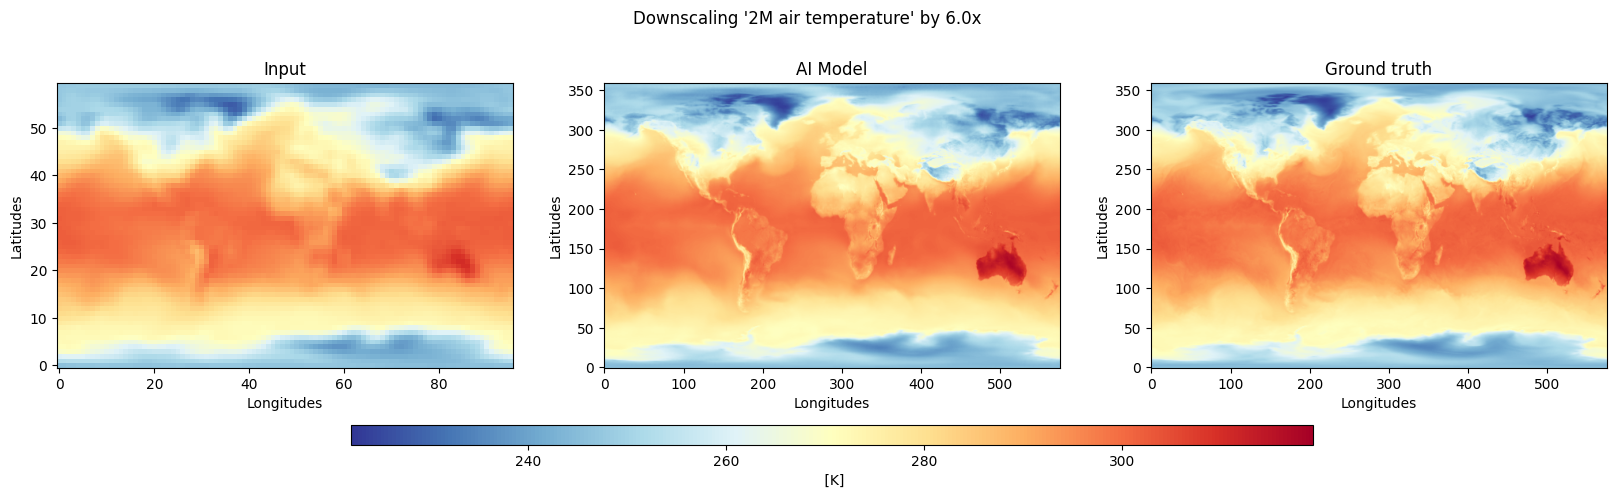

In [16]:
plot_val_kwargs = dict(
    cmap='RdYlBu_r',
    vmin = min(np.min(plot_input), np.min(plot_target), np.min(plot_output)),
    vmax = max(np.max(plot_input), np.max(plot_target), np.max(plot_output)),
    plot_residual_kwargs = dict(
        cmap = 'bwr',
        vmin = -np.max(np.abs(plot_residual)),
        vamx = np.max(np.abs(plot_residual)),
    ),
    var_name_title=var_name_title,
    var_unit=var_unit
)

plot_model_results(
    [plot_input, plot_output, plot_target],
    ['Input', 'AI Model', 'Ground truth'],
    title=f"Downscaling '{var_name_title}' by {coarsening_factor}x",
    **plot_val_kwargs
)

Text(0.5, 1.0, 'Power spectrum of 2M air temperature')

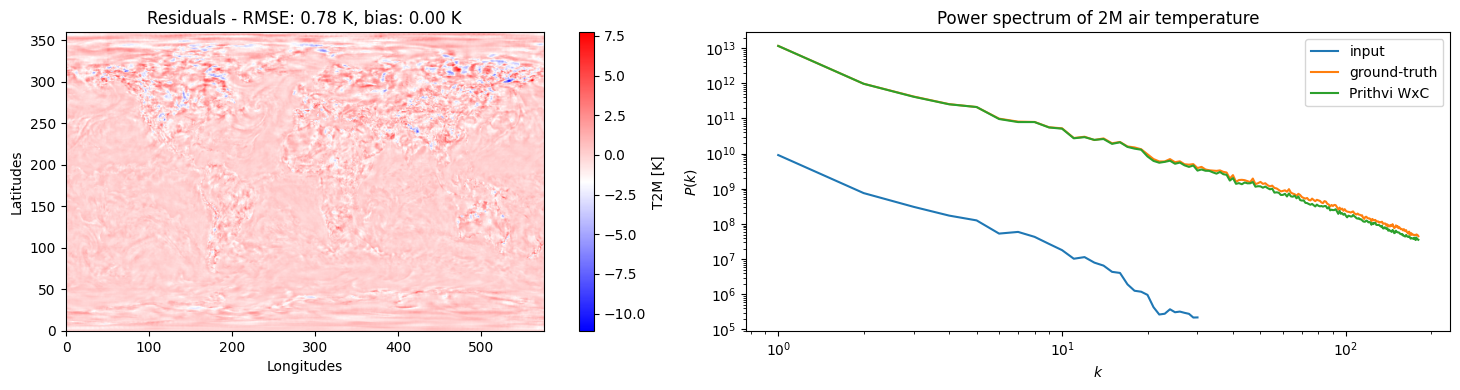

In [17]:
vmin_res = -np.max(np.abs(plot_residual))
vmax_res = np.max(np.abs(plot_residual))
pred_bias = spatial_bias(plot_output, plot_target)
pred_rmse = spatial_rmse(plot_output, plot_target)

fig, axs = plt.subplots(nrows=1,ncols=2,
                        figsize=(15,4))

title = 'Residuals - RMSE: {:.2f} K, bias: {:.2f} K'.format(pred_rmse, pred_bias)
im_res = plot_spatial(plot_residual, axs[0], title,  **plot_val_kwargs.get('plot_residual_kwargs'))
cbar = plt.colorbar(im_res, ax=axs[0], orientation='vertical', label=f'{var_name} [K]')

plot_power_spectrum(plot_input, axs[1])
plot_power_spectrum(plot_target, axs[1])
plot_power_spectrum(plot_output, axs[1])
axs[1].legend(['input', 'ground-truth', 'Prithvi WxC'])
axs[1].set_title(f'Power spectrum of {var_name_title}')